In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from scipy import stats
from pymc3 import Continuous
from theano import tensor 
#exp, log, sqrt

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 12

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, gamma, trise, tfall):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))

In [3]:
#These are the values we are going to use for a test
np.random.seed(212)
trise_A = 9.1
tfall_A = 13
Amplitude_A = 1500
Beta_A = -1
t0_A = 43.2
gamma_A = 60
end_A = 500
size = 10 #data set size double for total observations
sigma_A = 100 #Telescope error

In [4]:
time_axis_rise = np.random.uniform(low=0, high=(gamma_A+t0_A), size=size)
time_axis_rise = np.sort(time_axis_rise)
time_axis_fall = np.random.uniform(low=(gamma_A+t0_A), high=end_A, size=size)
time_axis_fall = np.sort(time_axis_fall)
Y_actual_rise = SuperNova_CurveRise(time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A)
Y_actual_fall = SuperNova_CurveFall(time_axis_fall, Amplitude_A, Beta_A, t0_A, gamma_A, trise_A, tfall_A)
time_axis = np.append(time_axis_rise, time_axis_fall)
Y_actual = np.append(Y_actual_rise, Y_actual_fall)
Y_observed = Y_actual + np.random.normal(0,sigma_A, len(Y_actual))
#Y_observed = Y_actual

Text(0.5, 1.0, 'Actual Light Curve')

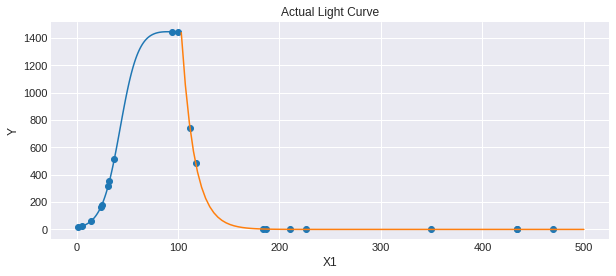

In [5]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_actual)

big_time_axis_rise = np.linspace(0,(gamma_A+t0_A),num = 100)
axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A))

big_time_axis_fall = np.linspace((gamma_A+t0_A),end_A,num = 100)
axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A, Beta_A, t0_A, gamma_A, trise_A, tfall_A))

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Actual Light Curve")

Text(0.5, 1.0, 'Observed Light Curve')

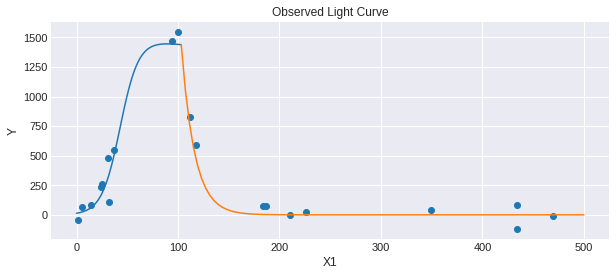

In [6]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_observed)

big_time_axis_rise = np.linspace(0,(gamma_A+t0_A),num = 100)
axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A))

big_time_axis_fall = np.linspace((gamma_A+t0_A),end_A,num = 100)
axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A, Beta_A, t0_A, gamma_A, trise_A, tfall_A))

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

(111.7835330927507, -15.211968197174187)


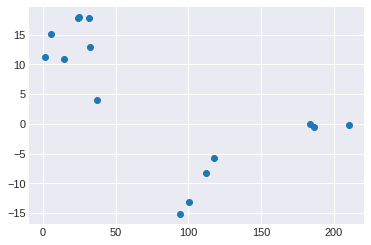

In [7]:
step = int(np.ceil(size/2))
if step<1:
    step = 1
slopes = []
least_slope = (0, 0)
for i in range(len(time_axis)-step):
    if step > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(time_axis[i:i+step],Y_observed[i:i+step])
    else:
        slope = (Y_observed[i]-Y_observed[i+step])/(time_axis[i]-time_axis[i+step])
    slopes.append(slope)
    if(slope < least_slope[1]):
        least_slope = (time_axis[i+int(np.floor(step/2))], slope)
print(least_slope)
plt.scatter(time_axis[0:len(time_axis)-step], slopes)

In [8]:
basic_model = pm.Model()

In [9]:
with basic_model:

    # Priors for unknown model parameters
    
    trise = pm.Uniform('trise', lower = 0.01, upper = 50)
    tfall = pm.Uniform('tfall', lower = 1, upper = 300)
    Amp_Guess = np.max(Y_observed)-np.min(Y_observed)
    Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)
    Beta = pm.Uniform('Beta', lower = -np.max(Y_observed)/150, upper = 0)
    t0 = pm.Uniform('t0', lower = np.min(time_axis), upper = np.max(time_axis))
    sigma = pm.HalfNormal('sigma', sigma=sigma_A)
    
    #gamma = pm.Uniform('gamma', lower = np.min(time_axis), upper = np.max(time_axis), testval = (least_slope[0]-))
    no_p = pm.Normal.dist(mu = 5, sigma = 5)
    yes_p = pm.Normal.dist(mu = 60, sigma = 30)
    
    gamma = pm.Mixture("gamma", w=[2/3,1/3], comp_dists = [no_p, yes_p])
    #gamma = pm.math.sum(pm.Normal("no_p", mu = 5, sigma = 5),pm.Normal("yes_p", mu = 60, sigma = 30))
    
    # Expected value of outcome
    mu_rise = SuperNova_CurveRise(time_axis, Amplitude, Beta, t0, trise)
    mu_fall = SuperNova_CurveFall(time_axis, Amplitude, Beta, t0, gamma, trise, tfall)
    
    mu_switch = pm.math.switch(gamma+t0 >= time_axis, mu_rise, mu_fall)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed)
    
    

KeyboardInterrupt: 

In [ ]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

In [ ]:
with basic_model:
    # 1000 posterior samples
    trace = pm.sample(10000, cores = 6)

In [ ]:
pm.plot_posterior(trace)

In [ ]:
%matplotlib inline
pm.traceplot(trace)

In [ ]:
summary_table = pm.summary(trace)
summary_table

In [ ]:
trise_R = summary_table["mean"]["trise"]
tfall_R = summary_table["mean"]["tfall"]
Amplitude_R = summary_table["mean"]["Amplitude"]
Beta_R = summary_table["mean"]["Beta"]
t0_R = summary_table["mean"]["t0"]
gamma_R = summary_table["mean"]["gamma"]

In [ ]:
print(trise_R, trise_A)
print(tfall_R, tfall_A)
print(Amplitude_R, Amplitude_A)
print(Beta_R, Beta_A)
print(t0_R, t0_A)
print(gamma_R, gamma_A)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t0_R+gamma_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t0_R+gamma_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, gamma_R, trise_R, tfall_R))

ax.errorbar(time_axis, Y_observed, sigma_A, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y_observed')

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t0_R+gamma_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t0_R+gamma_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, gamma_R, trise_R, tfall_R))

ax.scatter(time_axis, Y_actual)
ax.set_xlabel('x')
ax.set_ylabel('y_actual')